In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, START, END

from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
)

from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

from pydantic import BaseModel,Field
from typing_extensions import TypedDict
from typing import List, Optional
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import os
from dotenv import load_dotenv 
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import RetryOutputParser
import os.path

from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError




load_dotenv()
GOOGLE_API_KEY=os.getenv('google_api_key')

In [2]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [3]:
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json")
try:
    # create gmail api client
    service = build("people", "v1", credentials=creds)

except HttpError as error:
    print(f"An error occurred: {error}")

In [4]:
class State(TypedDict):
    """
    A dictionnary representing the state of the agent.
    """
    node_message:str
    query: str
    contacts: dict
    contact_details: dict
    route: str

In [5]:
def router_node(state=State):
    route=state.get('route')
    if route=="create_contact":
        return 'to_create_contact' 
    elif route=="get_contact_details":
        return 'to_get_contact_details'
    elif route=='delete_contact':
        return 'to_delete_contact'
    elif route=='update_contact':
        return 'to_get_contact_details'
    elif route=='show_contacts':
        return 'to_show_contacts'

In [6]:
def update_contact_route(state:State):
    route=state.get('route')
    if route == 'update_contact':
        return 'to_update_contact'
    else:
        return 'to_END'

In [7]:
class Address(BaseModel):
    city: Optional[str] = Field(None, description="The city of the address.")
    region: Optional[str] = Field(None, description="The region of the address; for example, the state or province.")
    streetAddress: Optional[str] = Field(None, description="The street address.")
    country: Optional[str] = Field(None, description="The country of the address.")
    postalCode: Optional[str] = Field(None, description="The postal code of the address.")
    extendedAddress: Optional[str] = Field(None, description="The extended address of the address; for example, the apartment number.")
    type: Optional[str] = Field(None, description="The type of the address. Can be custom or predefined: 'home', 'work', 'other'.")

class PhoneNumber(BaseModel):
    type: Optional[str] = Field(None, description="The type of the phone number. Can be custom or predefined: 'home', 'work', 'mobile', 'homeFax', 'workFax', 'otherFax', 'pager', 'workMobile', 'workPager', 'main', 'googleVoice', 'other'.")
    value: Optional[str] = Field(None, description="The phone number.")

class Name(BaseModel):
    middleName: Optional[str] = Field(None, description="The middle name(s).")
    familyName: Optional[str] = Field(None, description="The family name.")
    givenName: Optional[str] = Field(None, description="The given name.")

class Date(BaseModel):
    year: Optional[int] = Field(None, description="Year of date. Must be from 1 to 9999, or 0 if specifying a date without a year.")
    day: Optional[int] = Field(None, description="Day of month. Must be from 1 to 31 and valid for the year and month, or 0 if specifying a year by itself or a year and month where the day is not significant.")
    month: Optional[int] = Field(None, description="Month of year. Must be from 1 to 12, or 0 if specifying a year without a month and day.")

class Birthday(BaseModel):
    date: Date = Field(None, description="The date of the birthday.")
    # text: Optional[str] = Field(None, description="A free-form string representing the user's birthday.")

class Biography(BaseModel):
    value: Optional[str] = Field(None, description="The short biography.")

class EmailAddress(BaseModel):
    type: Optional[str] = Field(None, description="The type of the email address. Can be custom or predefined: 'home', 'work', 'other'.")
    displayName: Optional[str] = Field(None, description="The display name of the email.")
    value: Optional[str] = Field(None, description="The email address.")

class ContactBody(BaseModel):
    addresses: Optional[List[Address]] = Field(None, description="The person's street addresses.")
    phoneNumbers: Optional[List[PhoneNumber]] = Field(None, description="The person's phone numbers.")
    names: Optional[List[Name]] = Field(None, description="The person's names.")
    birthdays: Optional[List[Birthday]] = Field(None, description="The person's birthdays.")
    biographies: Optional[List[Biography]] = Field(None, description="The person's biographies.")
    emailAddresses: Optional[List[EmailAddress]] = Field(None, description="The person's email addresses.")

In [8]:
store=InMemoryStore()

In [9]:

def update_contacts_list_node(state: State):
    """
    Tool to display a list of contacts and their resource name to use to get a specific contacts details
    args: none
    """
    
    try:
        results = (
            service.people()
            .connections()
            .list(
                resourceName="people/me",
                pageSize=100,
                personFields="names",
            )
            .execute()
        )
        connections = results.get("connections", [])
        contact={}
        for person in connections:
            resourcename=person.get('resourceName')
            etag=person.get('etag')
            names = person.get("names", [])
            if names:
                name = names[0].get("displayName")
            contact[name]={'resourcename':resourcename,
                            'etag':etag}
        return {'contacts':contact}
    except:
        return {'node_message':'failed'}


In [10]:
def show_contacts_node(state:State):
    contacts=state['contacts']

    return  {'contacts':contacts}

In [11]:
class contacts_agent:
    def __init__(self,llm:any):
        self.agent=self._setup(llm)
    def _setup(self,llm):
        def get_contact_details_node(state:State):

            class Resourcename_shema(BaseModel):
                    resourcename: str = Field(description='The resource name which is associated with the contact to get the details from')

            parser=JsonOutputParser(pydantic_object=Resourcename_shema)
            prompt = PromptTemplate(
            template="Answer the user query.\n{format_instructions}\n{query}\n",
            input_variables=["query"],
            partial_variables={"format_instructions": parser.get_format_instructions()},
            )

            
            chain = prompt | llm 
            try:
                response=chain.invoke({'query':f'based on this list of contacts: {state['contacts']}, return the details of the contact mentionned in this query:{state['query']}'}) 
                try:
                    response=parser.parse(response.content)
                    results=service.people().get(resourceName=response['resourcename'],personFields='names,addresses,phoneNumbers,birthdays,biographies,emailAddresses').execute()
                    return {'contact_details':results}
                except:
                    try:
                        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

                        prompt_value = prompt.format_prompt(query=state['query'])
                        response=retry_parser.parse_with_prompt(response.content, prompt_value) 
                
                        results=service.people().get(resourceName=response['resourcename'],personFields='names,addresses,phoneNumbers,birthdays,biographies,emailAddresses').execute()
                        return {'contact_details':results}
                    except:
                        return {'node_message':'failed'}
            except:
                        return {'node_message':'failed'}
                
        def update_contact_node(state: State):
            # class Resourcename_shema(BaseModel):
            #     resourcename: str = Field(description='The resource name which is associated with the contact to get the details from')

            # parser=JsonOutputParser(pydantic_object=Resourcename_shema)
            # prompt = PromptTemplate(
            # template="Answer the user query.\n{format_instructions}\n{query}\n",
            # input_variables=["query"],
            # partial_variables={"format_instructions": parser.get_format_instructions()},
            # )

            
            # chain = prompt | llm 
            # try:
            #     response=chain.invoke({'query':f'based on this list of contacts: {state['contacts']}, return the details of the contact mentionned in this query:{state['query']}'}) 
            #     try:
            #         response=parser.parse(response.content)
            #         results=service.people().get(resourceName=response['resourcename'],personFields='names,addresses,phoneNumbers,birthdays,biographies,emailAddresses').execute()
                  
            #     except:
            #         try:
            #             retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

            #             prompt_value = prompt.format_prompt(query=state['query'])
            #             response=retry_parser.parse_with_prompt(response.content, prompt_value) 
                
            #             results=service.people().get(resourceName=response['resourcename'],personFields='names,addresses,phoneNumbers,birthdays,biographies,emailAddresses').execute()
            #         except:
            #             bla=bla
            # except:
            #      bla=bla
                           
                    
            class Address(BaseModel):
                city: Optional[str] = Field(None, description="The city of the address.")
                region: Optional[str] = Field(None, description="The region of the address; for example, the state or province.")
                streetAddress: Optional[str] = Field(None, description="The street address.")
                country: Optional[str] = Field(None, description="The country of the address.")
                postalCode: Optional[str] = Field(None, description="The postal code of the address.")
                extendedAddress: Optional[str] = Field(None, description="The extended address of the address; for example, the apartment number.")
                type: Optional[str] = Field(None, description="The type of the address. Can be custom or predefined: 'home', 'work', 'other'.")

            class PhoneNumber(BaseModel):
                type: Optional[str] = Field(None, description="The type of the phone number. Can be custom or predefined: 'home', 'work', 'mobile', 'homeFax', 'workFax', 'otherFax', 'pager', 'workMobile', 'workPager', 'main', 'googleVoice', 'other'.")
                value: Optional[str] = Field(None, description="The phone number.")

            class Name(BaseModel):
                middleName: Optional[str] = Field(None, description="The middle name(s).")
                familyName: Optional[str] = Field(None, description="The family name.")
                givenName: Optional[str] = Field(None, description="The given name.")

            class Date(BaseModel):
                year: Optional[int] = Field(None, description="Year of date. Must be from 1 to 9999, or 0 if specifying a date without a year.")
                day: Optional[int] = Field(None, description="Day of month. Must be from 1 to 31 and valid for the year and month, or 0 if specifying a year by itself or a year and month where the day is not significant.")
                month: Optional[int] = Field(None, description="Month of year. Must be from 1 to 12, or 0 if specifying a year without a month and day.")

            class Birthday(BaseModel):
                date: Date = Field(None, description="The date of the birthday.")
                # text: Optional[str] = Field(None, description="A free-form string representing the user's birthday.")

            class Biography(BaseModel):
                value: Optional[str] = Field(None, description="The short biography.")

            class EmailAddress(BaseModel):
                type: Optional[str] = Field(None, description="The type of the email address. Can be custom or predefined: 'home', 'work', 'other'.")
                displayName: Optional[str] = Field(None, description="The display name of the email.")
                value: Optional[str] = Field(None, description="The email address.")

            class UpdateBody(BaseModel):
                etag: str = Field(description='required the etag assoctiated with the contact.')
                addresses: Optional[List[Address]] = Field(None, description="The person's street addresses.")
                phoneNumbers: Optional[List[PhoneNumber]] = Field(None, description="The person's phone numbers.")
                names: Optional[List[Name]] = Field(None, description="The person's names.")
                birthdays: Optional[List[Birthday]] = Field(None, description="The person's birthdays.")
                biographies: Optional[List[Biography]] = Field(None, description="The person's biographies.")
                emailAddresses: Optional[List[EmailAddress]] = Field(None, description="The person's email addresses.")
            class Update_shema(BaseModel):
                updatePersonFields: str =Field(description="A field mask to restrict which fields on the person are updated. Multiple\
                fields can be specified by separating them with commas. eg. 'addresses,biographies'\
                All updated fields will be replaced. Valid values are:\
                * addresses\
                * biographies\
                * birthdays\
                * emailAddresses\
                * phoneNumbers"
                )
                body:UpdateBody = Field('the body of the contact to be updated')
                resourcename: str = Field(description='The resource name which is associated with the contact to be updated')

            parser=JsonOutputParser(pydantic_object=Update_shema)
            prompt = PromptTemplate(
            template="Answer the user query.\n{format_instructions}\n{query}\n",
            input_variables=["query"],
            partial_variables={"format_instructions": parser.get_format_instructions()},
            )

            
        
            chain = prompt | llm
            try:
                response=chain.invoke({'query':f'based on this contact: {state['contact_details']}, answer this query query:{state['query']}'}) 

                
                try:
                    response=parser.parse(response.content)
                    resourcename=state.get('contact_details').get('resourceName')

                    results=(service.people().updateContact(resourceName=resourcename, body=response['body'], updatePersonFields=response['updatePersonFields']).execute())
                    return {'node_message':results}
                except:
                    try:
                        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

                        prompt_value = prompt.format_prompt(query=state['query'])
                        response=retry_parser.parse_with_prompt(response.content, prompt_value) 
                        resourcename=response.get('resourcename')
                        results=(service.people().updateContact(resourceName=response['body'].get('resourcename'), body=response['body'], updatePersonFields=response['updatePersonFields']).execute())
                        return {'node_message':results}
                    except:
                        return {'node_message':'failed'} 
            except:
                        return {'node_message':'failed'}
         
                
        def create_contact_node(state:State):
  

            parser=JsonOutputParser(pydantic_object=ContactBody)
            prompt = PromptTemplate(
            template="Answer the user query.\n{format_instructions}\n{query}\n",
            input_variables=["query"],
            partial_variables={"format_instructions": parser.get_format_instructions()},
            )

            
            chain = prompt | llm 
            response=chain.invoke({'query':state['query']}) 
            try:
                response=parser.parse(response.content)
                results=service.people().createContact(body=response).execute()
                return {'node_message':results}
            except:
                try:
                    retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

                    prompt_value = prompt.format_prompt(query=state['query'])
                    response=retry_parser.parse_with_prompt(response.content, prompt_value)  
                    results=service.people().createContact(body=response).execute()
                    return {'node_message':results}
                except:
                    return {'node_message':'failed'}
            
        def delete_contact_node(state:State):
            class Resourcename_shema(BaseModel):
                resourcename: str = Field(description='The resource name which is associated with the contact to be deleted')

            parser=JsonOutputParser(pydantic_object=Resourcename_shema)
            prompt = PromptTemplate(
            template="Answer the user query.\n{format_instructions}\n{query}\n",
            input_variables=["query"],
            partial_variables={"format_instructions": parser.get_format_instructions()},
            )

            
            chain = prompt | llm 
            try:
                response=chain.invoke({'query':f'based on this list of contacts: {state['contacts']}, get the resource name of the contact mentionned in this query:{state['query']}'}) 
                try:
                    response=parser.parse(response.content)
                    
                    service.people().deleteContact(resourceName=response['resourcename']).execute()
                    return {'node_message':'contact deleted'}
                except:
                    try:
                        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

                        prompt_value = prompt.format_prompt(query=state['query'])
                        response=retry_parser.parse_with_prompt(response.content, prompt_value) 
                
                        service.people().deleteContact(resourceName=response['resourcename']).execute()
                        return  {'node_message':'contact deleted'}
                    except:
                        return {'node_message':'failed'}
            except:
                        return {'node_message':'failed'}
        
        def agent_node(state: State):
            class Form(BaseModel):
                route: str = Field(description='return one of these options: create_contact, get_contact_details, delete_contact, update_contact, show_contacts, current_loc, or look_for_places')
            
            parser = JsonOutputParser(pydantic_object=Form)
            instruction = parser.get_format_instructions()
            response = llm.invoke([HumanMessage(content=f'based on this query:{state["query"]}, return one of: create_contact, get_contact_details, delete_contact, update_contact, show_contacts'+'\n\n'+instruction)])
            response = parser.parse(response.content)
            response = response.get('route')
            return {'route': response}
            

        graph_builder = StateGraph(State)
        graph_builder.add_node('update_contact_list',update_contacts_list_node)
        graph_builder.add_node('agent',agent_node)
        graph_builder.add_node("create_contact", create_contact_node)
        graph_builder.add_node("get_contact_details", get_contact_details_node)
        graph_builder.add_node('delete_contact',delete_contact_node)
        graph_builder.add_node('update_contact',update_contact_node)
        graph_builder.add_node('show_contacts',show_contacts_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.add_edge(START,'update_contact_list')
        graph_builder.add_edge('update_contact_list','agent')
        graph_builder.add_conditional_edges(
            "agent",
            router_node,{
                            "to_create_contact": "create_contact",
                            "to_get_contact_details": "get_contact_details",
                            "to_delete_contact": "delete_contact",
                            "to_update_contact": "get_contact_details",
                            "to_show_contacts": "show_contacts"
                            }
        )
        graph_builder.add_edge('create_contact', END)
        graph_builder.add_conditional_edges('get_contact_details',update_contact_route, {"to_update_contact":'update_contact', 'to_END': END})
        graph_builder.add_edge("delete_contact",END)
        graph_builder.add_edge("update_contact",END)
        graph_builder.add_edge("show_contacts",END)


        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory, store=store)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input},config)
        return response

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input}, config, stream_mode="updates"):
            print(event)
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]

In [12]:
agent=contacts_agent(llm)

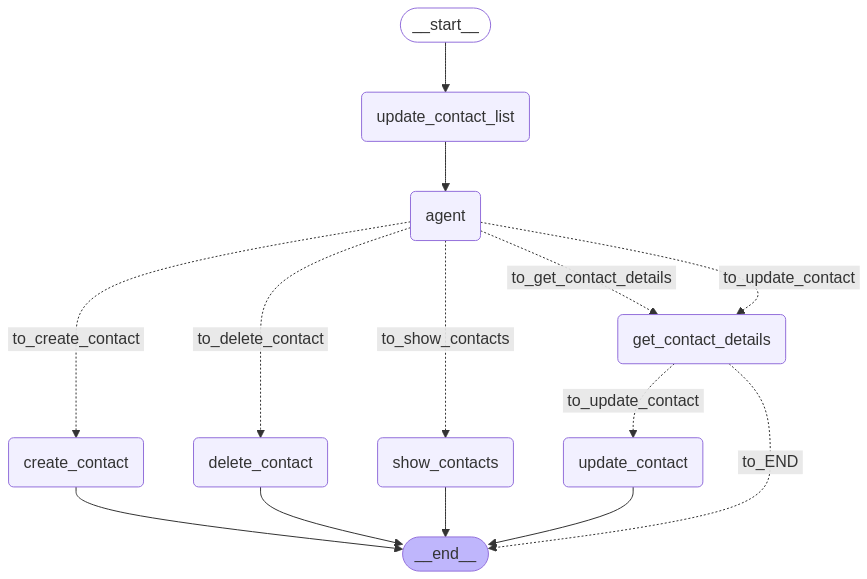

In [13]:
agent.display_graph()

In [16]:
response=agent.chat('show contacts details of johnny doe')

In [19]:
response

{'query': 'show contacts details of johnny doe',
 'contacts': {'Tristan Padiou': {'resourcename': 'people/c1444037682365792704',
   'etag': '%EgUBAi43PRoEAQIFByIMVkV1eDhZS1d6WUE9'},
  'Giselle Bogs': {'resourcename': 'people/c773801861794169656',
   'etag': '%EgUBAi43PRoEAQIFByIMQ2J5RjZJWWxHc3M9'},
  'pascale padiou': {'resourcename': 'people/c9136797831542164705',
   'etag': '%EgUBAi43PRoEAQIFByIMN1cxbFQzOXI1c0U9'},
  'Johnny Doe': {'resourcename': 'people/c7610783302568859438',
   'etag': '%EgUBAi43PRoEAQIFByIMak5sN0tJcitYeWM9'}},
 'contact_details': {'resourceName': 'people/c7610783302568859438',
  'etag': '%Eg0BAgUHCQsQLjc9Pj9AGgQBAgUHIgxqTmw3S0lyK1h5Yz0=',
  'names': [{'metadata': {'primary': True,
     'source': {'type': 'CONTACT', 'id': '699eef170c17572e'},
     'sourcePrimary': True},
    'displayName': 'Johnny Doe',
    'familyName': 'Doe',
    'givenName': 'Johnny',
    'displayNameLastFirst': 'Doe, Johnny',
    'unstructuredName': 'Johnny Doe'}],
  'emailAddresses': [{'metad

In [15]:
agent.get_state('contacts')

{'Tristan Padiou': {'resourcename': 'people/c1444037682365792704',
  'etag': '%EgUBAi43PRoEAQIFByIMVkV1eDhZS1d6WUE9'},
 'Giselle Bogs': {'resourcename': 'people/c773801861794169656',
  'etag': '%EgUBAi43PRoEAQIFByIMQ2J5RjZJWWxHc3M9'},
 'pascale padiou': {'resourcename': 'people/c9136797831542164705',
  'etag': '%EgUBAi43PRoEAQIFByIMN1cxbFQzOXI1c0U9'},
 'Johnny Doe': {'resourcename': 'people/c7610783302568859438',
  'etag': '%EgUBAi43PRoEAQIFByIMak5sN0tJcitYeWM9'}}